[ 10  97  99  76 123 100  63  62  60 105]
[255 255   0 255 255   0   0   0 255   0]


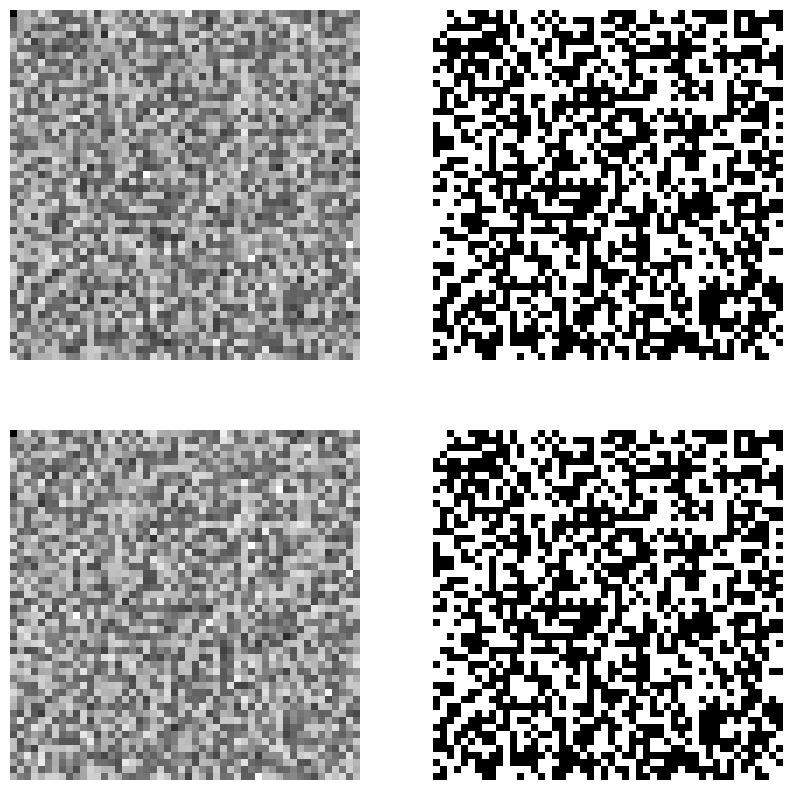

In [3]:

import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
from tqdm import trange

barcodeA = imread('MGBarcodesA/2Dbarcode1.pgm')
barcodeAOri = imread('MGBarcodesA/OriginalCode.pgm')

print(barcodeA.flatten()[:10])
print(barcodeAOri.flatten()[:10])

barcodeF = imread('MGBarcodesF/2Dbarcode1.pgm')
barcodeFOri = imread('MGBarcodesF/OriginalCode.pgm')

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
axes[0, 0].imshow(barcodeA, cmap="gray")
axes[0, 0].axis('off')
axes[0, 1].imshow(barcodeAOri, cmap="gray")
axes[0, 1].axis('off')

axes[1, 0].imshow(barcodeF, cmap="gray")
axes[1, 0].axis('off')
axes[1, 1].imshow(barcodeFOri, cmap="gray")
axes[1, 1].axis('off')
plt.show()

# Attaquant

In [5]:



def f(zi, mu, sigma2):
    return (1 / (np.sqrt(2 * np.pi) * sigma2)) * np.exp(-(zi - mu) ** 2 / (2 * sigma2))


def EMAlg(scan, N):
    K = 2
    alphas = np.ones(K) / K
    #mus = np.random.choice(scan, K)
    mus = np.array([50, 150], dtype=np.float64)
    #sigmas = np.ones(K)
    sigmas = np.array([100, 100], dtype=np.float64)
    scan_len = len(scan)

    for _ in trange(N):
        pnums = np.zeros((scan_len, K))
        for k in range(K):
            pnums[:, k] = alphas[k] * f(scan, mus[k], sigmas[k])

        pnums /= np.sum(pnums, axis=1, keepdims=True)

        for k in range(K):
            p_sum = np.sum(pnums[:, k])

            mus[k] = np.sum(scan * pnums[:, k]) / p_sum
            sigmas[k] = np.sum(pnums[:, k] * (scan - mus[k]) ** 2) / p_sum
            alphas[k] = p_sum / scan_len

    return alphas, mus, sigmas

In [14]:
test_scan = barcodeA.flatten()  #/ 255
alphas, mus, sigmas = EMAlg(test_scan, 100000)

print(alphas, mus, sigmas)

100%|██████████| 100000/100000 [00:16<00:00, 6104.60it/s]

[0.5007167 0.4992833] [ 64.69383994 105.36926437] [111.47382256 113.32544342]


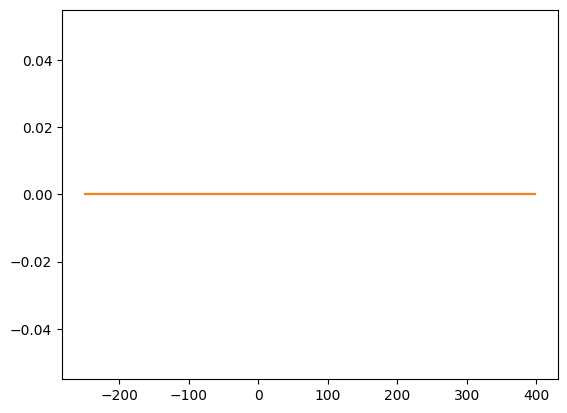

In [73]:
from scipy.stats import norm

#x_axis = np.arange(0.20, 0.45, 0.0001)
x_axis = np.arange(-250, 400, 1)

plt.plot(x_axis, norm.pdf(x_axis, mus[0], sigmas[0]))
plt.plot(x_axis, norm.pdf(x_axis, mus[1], sigmas[1]))
plt.show()

85.03155215926648
[ 10  97  99 ...  69  60 114]
[  0 255 255   0 255 255   0   0   0 255   0 255   0 255 255 255   0 255
   0 255]
[ 10  97  99  76 123 100  63  62  60 105  85 121  48 100 111  97  61 101
  54 114]
[255 255   0 255 255   0   0   0 255   0 255   0 255 255 255   0 255   0
 255 255]
48.68%


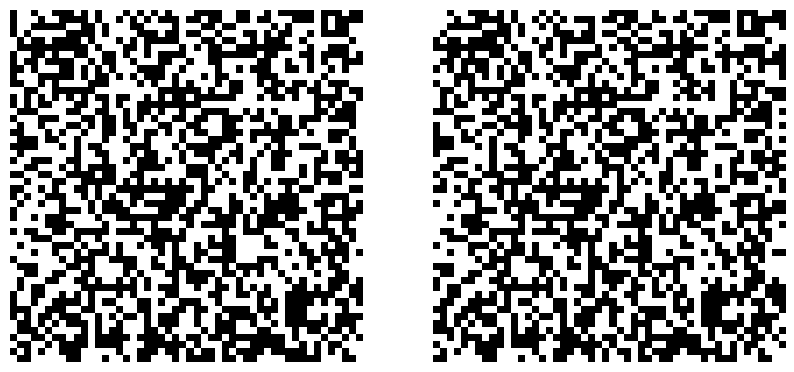

In [15]:
seuil = np.mean(mus)
tmp_sigs = sigmas / np.sum(sigmas)
#seuil = (max(mus) - min(mus)) / tmp_sigs[0]
#seuil = (mus[1] * sigmas[0] - sigmas[1] * mus[0]) / (sigmas[1] - sigmas[0])
print(seuil)

print(test_scan)
test_orig = np.where(test_scan > seuil, 255, 0).reshape(50, 50)

print(test_orig.flatten()[:20])
print(barcodeA.flatten()[:20])
print(barcodeAOri.flatten()[:20])

fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
axes[0].imshow(test_orig, cmap="gray")
axes[0].axis('off')
axes[1].imshow(barcodeAOri, cmap="gray")
axes[1].axis('off')

print(f"{len(np.where(test_orig.flatten() == barcodeAOri.flatten())[0]) / 50 / 50 * 100}%")

# 2

In [76]:
mu1 = 65
mu2 = 105
sigma1 = sigma2 = 105
seuil = 85

#nbBlacks = len(np.where(image == 0)[0])
#nbWhite = len(np.where(image == 255)[0])

Pbw = 0
Pwb = 0

for k in range(256):
    if k < seuil:
        Pwb += f(k, mu2, sigma2)
    else:
        Pbw += f(k, mu1, sigma1)

#print(Pbw, Pwb)

mu3 = (1 - Pbw) * mu1 + Pbw * mu2
mu4 = (1 - Pwb) * mu2 + Pwb * mu1
sigma3 = (1 - Pbw) ** 2 * sigma1 + Pbw ** 2 * sigma2
sigma4 = (1 - Pwb) ** 2 * sigma2 + Pwb ** 2 * sigma1


def calcLambda(image, origin):
    N = image.shape[0] * image.shape[1]

    LAMBDA = 0
    imageFlat = image.flatten()
    originFlat = origin.flatten()
    for i in range(N):
        if originFlat[i] == 0:  # black
            LAMBDA += (imageFlat[i] - mu1) ** 2 / sigma1 ** 2 - (imageFlat[i] - mu3) ** 2 / sigma3 ** 2
        elif originFlat[i] == 255:
            LAMBDA += (imageFlat[i] - mu2) ** 2 / sigma2 ** 2 - (imageFlat[i] - mu4) ** 2 / sigma4 ** 2
    LAMBDA /= 2
    LAMBDA += N * np.log(np.sqrt(sigma1 * sigma2 / sigma3 / sigma4))
    #print(N * np.log(np.sqrt(sigma1 * sigma2 / sigma3 / sigma4)))
    #print(np.sqrt(sigma1 * sigma2 / sigma3 / sigma4))
    #print(N * np.log(np.sqrt(sigma1 * sigma2 / sigma3 / sigma4)))
    return LAMBDA

In [70]:
t1 = calcLambda(barcodeAOri, barcodeAOri)
t2 = calcLambda(barcodeA, barcodeAOri)
t3 = calcLambda(barcodeF, barcodeAOri)
t4 = calcLambda(test_orig, barcodeAOri)

print(t1, t2, t3, t4)

65.11113814501985 104.91148501010848
12.478266913995052
65.11113814501985 104.91148501010848
12.478266913995052
65.11113814501985 104.91148501010848
12.478266913995052
65.11113814501985 104.91148501010848
12.478266913995052
-3.886814053229399 11.866288421240384 11.883184734729236 -8.178595315817157


In [77]:
def relative_entropy(image, origin):
    imageFlat = image.flatten()
    originFlat = origin.flatten()
    N = len(originFlat)
    summ = 0
    for i in range(N):
        if originFlat[i] == 0:  # black
            summ += ((1 - Pbw) * f(imageFlat[i], mu1, sigma1) + Pbw * f(imageFlat[i], mu2, sigma2)) * np.log2(
                ((1 - Pbw) * f(imageFlat[i], mu1, sigma1) + Pbw * f(imageFlat[i], mu2, sigma2)) / f(imageFlat[i], mu1,
                                                                                                    sigma1))
        elif originFlat[i] == 255:
            summ += ((1 - Pwb) * f(imageFlat[i], mu2, sigma2) + Pwb * f(imageFlat[i], mu1, sigma1)) * np.log2(
                ((1 - Pwb) * f(imageFlat[i], mu2, sigma2) + Pwb * f(imageFlat[i], mu1, sigma1)) / f(imageFlat[i], mu2,
                                                                                                    sigma2))
    return summ

In [83]:
goods = []
goodsEnt = []
orrrrrr = imread(f"BarcodesA/OriginalCode.pgm")
for i in trange(1, 10001):
    img = imread(f"BarcodesA/2Dbarcode{i}.pgm")
    lm = calcLambda(img, orrrrrr)
    goods.append(lm)
    goodsEnt.append(relative_entropy(img, orrrrrr))

fakes = []
fakesEnt = []
for i in trange(1, 10001):
    img = imread(f"BarcodesF/2Dbarcode{i}.pgm")
    lm = calcLambda(img, orrrrrr)
    fakes.append(lm)
    fakesEnt.append(relative_entropy(img, orrrrrr))

100%|██████████| 10000/10000 [01:45<00:00, 95.03it/s]


In [84]:
print(goodsEnt[:10])
print(fakesEnt[:10])

[0.0010034251077461922, 0.0015961801733534787, 0.0016600547611027496, 0.0015036653843743216, 0.0012427841496344093, 0.0019452023724826524, 0.001404711463242372, 0.0012955279673721005, 0.0016443515397725084, -0.0025012197413608133]
[0.001647740197953102, 0.001932396834665559, 0.0014094951383684085, 0.001479837858582503, 0.0014719742407561587, 0.0014880382262986282, 0.0017018328470743695, 0.0014910947595879916, 0.0015715265801927584, 0.0012971873697003881]


[ 188 2938 5544 1131    9    0    0    0   60  130] [1.20804441 1.21392256 1.21980072 1.22567887 1.23155702 1.23743518
 1.24331333 1.24919148 1.25506964 1.26094779 1.26682594]


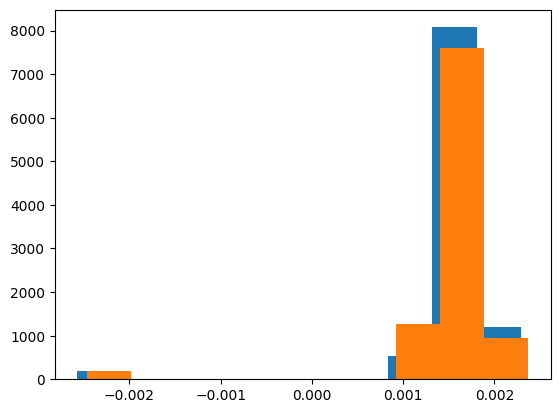

In [85]:
a, counts = np.histogram(fakes)
print(a, counts)

plt.hist(goodsEnt)
plt.hist(fakesEnt)
plt.show()